We were given the task of comparing the peak widths of $Ni_{30}Co$ after specific heat treatments. In particular, we wanted to see if there were significant changes in the peak widths. Although it would be possible to get a point estimate of the change in peak width quite easily, we're attempting to check ~5nm changes in the average grain size, and thus opt to use a Poisson Process to model the XRD scan, in order to check that the hypothesized changes in the peak widths are statistically significant. With the model, we establish statistical methodologies for determining a peak's width. We determine the background average count and standard deviation, and when the count $f$ at a particular theta exceeds the background average count by a particular $\alpha\sigma$, where $\alpha$ is an arbitrary constant, we observe that there is a peak bound at $f\pm\alpha\sigma$, where $f\pm\alpha\sigma<f$. Moreover, for every $f_i\pm\alpha\sigma$ we identify a peak bound $f_{i+1}\mp\alpha\sigma$ for which $\theta_{i+1}>\theta$. We then use a Hamiltonian Monte Carlo to estimate the integral under each peak bound pair, which incorporates the model's certainty about each count estimate $\mathbf{E}(f)$.

In [1]:
import matplotlib
matplotlib.use('svg')
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print(get_available_gpus())

['/gpu:0']


In [2]:
import GPy
import gpflow
import seaborn as sns
import itertools
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
import numpy as np
import copy
import h5py
import edward as ed
import keras.backend as K
from tensorflow.python.ops import array_ops
from edward.models import Normal, Uniform, MultivariateNormalTriL
from edward.util import rbf
from sklearn.metrics import log_loss
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
sns.set()
config = tf.ConfigProto(allow_soft_placement = True,log_device_placement=True)
sess = tf.Session(config=config)

Let's load up our XRD data.

In [4]:
skip = list(range(1,183))
[skip.append(row) for row in range(2401,2403)]
df_AD = pd.read_table('../data/XRD/JA-AD-20min.ras',engine='python',skiprows=183,\
                   skipfooter=2,header=None,delim_whitespace=True)
X_AD = np.expand_dims(df_AD.values[:,0],axis=-1)
Y_AD = np.expand_dims(df_AD.values[:,1],axis=-1)

df_200 = pd.read_table('../data/XRD/JA-200-20min.ras',engine='python',skiprows=183,\
                   skipfooter=2,header=None,delim_whitespace=True)
X_200 = np.expand_dims(df_200.values[:,0],axis=-1)
Y_200 = np.expand_dims(df_200.values[:,1],axis=-1)

df_225 = pd.read_table('../data/XRD/JA-225-20min.ras',engine='python',skiprows=183,\
                   skipfooter=2,header=None,delim_whitespace=True)
X_225 = np.expand_dims(df_225.values[:,0],axis=-1)
Y_225 = np.expand_dims(df_225.values[:,1],axis=-1) 

df_250 = pd.read_table('../data/XRD/JA-250-20min.ras',engine='python',skiprows=183,\
                   skipfooter=2,header=None,delim_whitespace=True)
X_250 = np.expand_dims(df_250.values[:,0],axis=-1)
Y_250 = np.expand_dims(df_250.values[:,1],axis=-1) 

df_300 = pd.read_table('../data/XRD/JA-300-20min.ras',engine='python',skiprows=183,\
                   skipfooter=2,header=None,delim_whitespace=True)
X_300 = np.expand_dims(df_250.values[:,0],axis=-1)
Y_300 = np.expand_dims(df_250.values[:,1],axis=-1) 

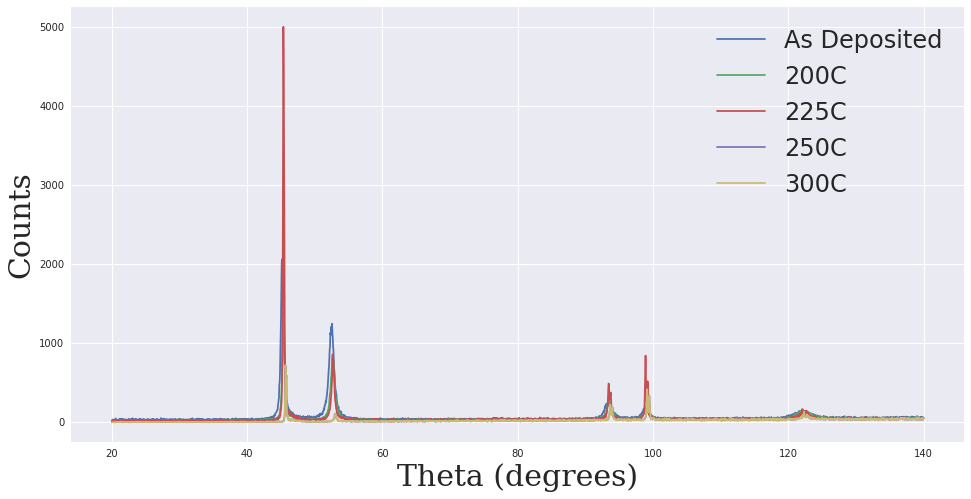

In [5]:
import matplotlib.font_manager as font_manager
axis_font = {'fontname':'DejaVu Serif', 'size':'30'}
font_prop = font_manager.FontProperties(size=24)
plt.figure(figsize=(16,8))
plt.plot(X_AD,Y_AD)
plt.plot(X_200,Y_200)
plt.plot(X_225,Y_225)
plt.plot(X_250,Y_250)
plt.plot(X_300,Y_300)
plt.xlabel('Theta (degrees)',**axis_font)
plt.ylabel('Counts',**axis_font)
plt.legend(['As Deposited','200C','225C','250C','300C'],prop=font_prop)
plt.savefig('XRD_initial.svg')

Since this is based on counting the number of occurrences of a phenomena, the noise is from a Poisson process.Thus, we fit a Poisson likelihood function with a radial basis function, using sparse variational inference.

Caught KeyboardInterrupt, setting                   model with most recent state.


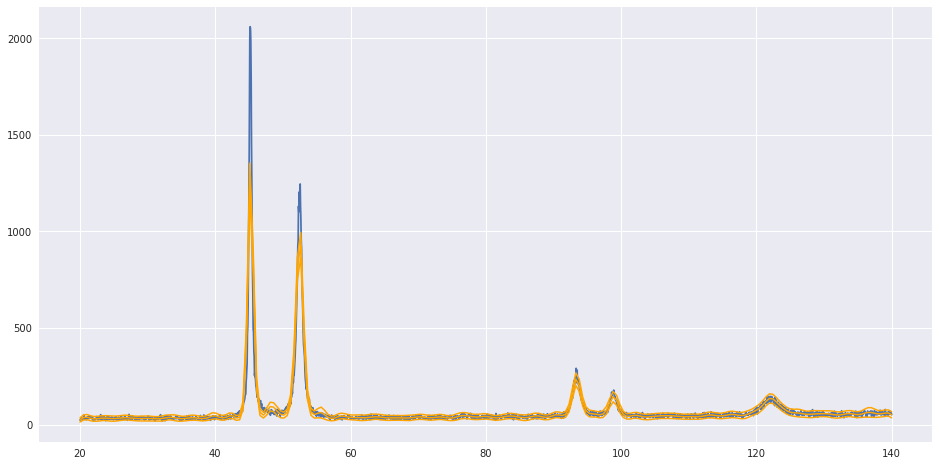

In [42]:
D = X_AD.shape[1]
kernel = gpflow.kernels.RBF(D,1)
likelihood = gpflow.likelihoods.Poisson()
#Z = X_AD[:750].copy()
approximate_maxima = np.random.choice(range(len(X_AD)),size=1000,p=(Y_AD.flatten()/np.sum(Y_AD)))
m = gpflow.svgp.SVGP(X_AD, Y_AD, kernel,likelihood=likelihood,Z=X_AD[approximate_maxima],minibatch_size=len(X_AD))
m.optimize()
#m.kern.variance.prior = gpflow.priors.Gamma(2,0.01)
pX = np.linspace(20, 140,num=240)[:, None]
pY, pYv = m.predict_y(pX)
plt.figure(figsize=(16,8))
plt.plot(X_AD,Y_AD)
line, = plt.plot(pX, pY, color='orange',lw=1.5)
plt.plot(pX, pY+2*pYv**0.5, color='orange', lw=1.5)
plt.plot(pX, pY-2*pYv**0.5, color='orange', lw=1.5)
#plt.plot(m.Z.value, np.zeros(m.Z.value.shape), 'k|', color='orange', mew=2)

Now let's generate some points around the maxima, and pick what points the model believes to be the local maxima, then evaluate the confidence interval at each maxima.

In [63]:
from sklearn.cluster import KMeans
    
approximate_maxima = np.random.choice(range(len(X_AD)),size=200,p=(Y_AD.flatten()/np.sum(Y_AD)))
thetas = X_AD[approximate_maxima].flatten() + np.random.rand(len(approximate_maxima))
pY, pYv = m.predict_y(np.expand_dims(thetas,axis=-1))
counts = pY.
maxima = []
stdev = []

kmeans = KMeans(n_clusters=5)
kmeans.fit(thetas)

    
for pX in groups:
    pY, pYv = m.predict_y(np.expand_dims(pX,axis=-1))
    maximum = np.argmax(pY)
    maxima.append(pX[maximum])
    stdev.append(pYv[maximum])

print('Local Maxima: {}'.format(maxima))
print('Standard Deviations: {}'.format(stdev))

20.9261924204
32.3085069808
128.908586024
Local Maxima: [20.926192420415479, 45.194193688165775, 136.72183414740135]
Standard Deviations: [array([ 45.50058251]), array([ 1561.56740042]), array([ 159.2616912])]
